## Credit Card Transanctions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
#read dataset
cc_info = pd.read_csv('/Users/reggieyang/Dropbox/Semester C/Take Home Challenges/Project Challenges/Credit Card Transactions/credit_card/cc_info.csv')
trans = pd.read_csv('/Users/reggieyang/Dropbox/Semester C/Take Home Challenges/Project Challenges/Credit Card Transactions/credit_card/transactions.csv',parse_dates=['date'])


In [3]:
trans.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [4]:
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


# Q1

Your boss wants to identify those users that in your dataset never went above the monthly credit card limit calendar month. The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [5]:
data = pd.merge(trans, cc_info, on='credit_card',how='left')
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [6]:
data['month'] = data['date'].apply(lambda x:x.month)

In [7]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10


In [8]:
grouped_data = data.groupby(['credit_card','month']).agg({'transaction_dollar_amount':'sum','credit_card_limit':'mean'})
grouped_data = grouped_data.reset_index()

In [9]:
grouped_data['exceeded'] = (grouped_data['transaction_dollar_amount']>grouped_data['credit_card_limit']).astype(int)

In [10]:
grouped_data_sum = grouped_data.groupby('credit_card').agg({'exceeded':'sum'})
grouped_data_sum = grouped_data_sum.reset_index()

In [11]:
valid_cc = grouped_data_sum[grouped_data_sum['exceeded']==0]['credit_card'].unique()

In [12]:
valid_cc.shape

(862,)

# Q2

On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [13]:
data['day'] = data['date'].apply(lambda x:x.day)
data['year'] = data['date'].apply(lambda x:x.year)

In [14]:
def limit_alert(data,year,month,day):
    date_data = data[(data['month']==month) & (data['day']<=day)]
    grouped_data = date_data.groupby(['credit_card','month']).agg({'transaction_dollar_amount':'sum','credit_card_limit':'mean'}).reset_index()
    return (grouped_data[grouped_data['transaction_dollar_amount']>grouped_data['credit_card_limit']]['credit_card'])
    

In [15]:
limit_alert(data,year=2015,month=9,day=22)

8      1106824181265726
144    2245942585429940
168    2505223645294729
241    3281814060807145
254    3369600965634913
338    4052848131106690
529    5723635641134781
539    5795626689544539
579    6174559182308122
599    6292410823269309
640    6766253113444560
662    6984795534098127
700    7299183791723634
703    7324887971716592
872    8896425420278012
877    8972201384562696
Name: credit_card, dtype: int64

## Q3

Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

In [16]:
#get cities' geographic infomation
from geopy.geocoders import Nominatim

In [17]:
cc_info2 = cc_info.copy()
cc_city = cc_info2['city'].unique()

Extract longitude and latitude of all the cities

In [18]:
# cc_city_dict = {}
# for city in cc_city:
#     geolocator = Nominatim(user_agent="fraud detection")
#     location = geolocator.geocode(city)
#     if location!=None:
#         cc_city_dict[city]=(location.latitude, location.longitude)

In [19]:
cc_city_dict={
 'Dallas': (32.7762719, -96.7968559),
 'Houston': (29.7589382, -95.3676974),
 'Auburn': (32.527002, -85.4367484053398),
 'Orlando': (28.5421097, -81.3790388),
 'New York': (40.7127281, -74.0060152),
 'Atlanta': (33.7490987, -84.3901849),
 'Pittsburgh': (40.4416941, -79.9900861),
 'Birmingham': (52.4775396, -1.894053),
 'Washington': (38.8950092, -77.0365625),
 'Los Angeles': (34.0536909, -118.2427666),
 'Phoenix': (33.4485866, -112.0773456),
 'Colorado Springs': (38.8339578, -104.8253485),
 'San Francisco': (37.7792808, -122.4192363),
 'Columbus': (39.9622601, -83.0007065),
 'Topeka': (39.049011, -95.677556),
 'El Paso': (31.7600372, -106.487287),
 'Corpus Christi': (27.8002542, -97.3955744),
 'Richmond': (37.5385087, -77.43428),
 'Sacramento': (38.5815719, -121.4943996),
 'Arlington': (32.701939, -97.105624826688),
 'Cleveland': (41.5051613, -81.6934446),
 'Tacoma': (47.2495798, -122.4398746),
 'San Diego': (32.7174209, -117.1627714),
 'Springfield': (39.7990175, -89.6439575),
 'Chicago': (41.8755616, -87.6244212),
 'Seattle': (47.6038321, -122.3300624),
 'Albany': (42.6511674, -73.754968),
 'Kansas City': (39.100105, -94.5781416),
 'Denver': (39.7392364, -104.9848623),
 'Oklahoma City': (35.4729886, -97.5170536),
 'Las Vegas': (36.1662859, -115.149225),
 'Raleigh': (35.7803977, -78.6390989),
 'Pasadena': (34.1476452, -118.1444779),
 'Memphis': (35.1490215, -90.0516285),
 'Des Moines': (41.5910641, -93.6037149),
 'Miami': (25.7742658, -80.1936589),
 'Portland': (45.5202471, -122.6741949),
 'Buffalo': (42.8867166, -78.8783922),
 'Long Beach': (33.7690164, -118.1916048),
 'Newark': (40.735657, -74.1723667),
 'San Antonio': (29.4246002, -98.4951405),
 'Indianapolis': (39.7683331, -86.1583502),
 'Fort Worth': (32.753177, -97.3327459),
 'Akron': (41.083064, -81.518485),
 'New Orleans': (29.9499323, -90.0701156),
 'Saint Louis': (38.6268039, -90.1994097),
 'Salt Lake City': (40.7670126, -111.8904308),
 'Fresno': (36.7295295, -119.708861260756),
 'Cincinnati': (39.1014537, -84.5124602),
 'Austin': (30.2711286, -97.7436995),
 'Dover': (51.1299804, 1.308319),
 'San Jose': (37.3361905, -121.8905833),
 'Trenton': (40.2170575, -74.7429463),
 'Oakland': (37.8044557, -122.2713563),
 'Gretna': (36.9528412, -79.3602341),
 'Clinton': (38.5896187, -89.420064),
 'Honolulu': (21.304547, -157.8556764),
 'Charleston': (32.7876012, -79.9402728),
 'Dayton': (39.7589478, -84.1916069),
 'Mobile': (30.6943566, -88.0430541),
 'Charlotte': (35.2270869, -80.8431268),
 'Philadelphia': (39.9527237, -75.1635262),
 'Madison': (43.074761, -89.3837613),
 'Newport': (51.5882332, -2.9974967),
 'Lafayette': (30.2240897, -92.0198427),
 'Pensacola': (30.421309, -87.2169149),
 'Jacksonville': (30.3321838, -81.655651),
 'Greensboro': (36.0726355, -79.7919754),
 'Shreveport': (32.5221828, -93.7651944),
 'Saint Paul': (44.9504037, -93.1015026),
 'Huntington': (38.4192496, -82.445154),
 'Jackson': (32.2990384, -90.1847691),
 'Lexington': (38.0464066, -84.4970393),
 'Rochester': (43.157285, -77.615214),
 'Minneapolis': (44.9706705, -93.268217735811),
 'Columbia': (2.8894434, -73.783892),
 'Louisville': (38.2542376, -85.759407),
 'Boston': (42.3602534, -71.0582912),
 'New Haven': (41.3082138, -72.9250518),
 'Wichita': (37.6922361, -97.3375448),
 'Bristol': (51.4538022, -2.5972985),
 'Hillsboro': (45.5228939, -122.989827),
 'Hartford': (41.764582, -72.6908547),
 'Friendship': (6.6561163, -58.1864606),
 'Omaha': (41.2587459, -95.9383758),
 'Tampa': (27.9477595, -82.458444),
 'Scranton': (41.4086874, -75.6621294),
 'Tulsa': (36.1556805, -95.9929113),
 'Cedar Rapids': (41.9758872, -91.6704053),
 'Troy': (39.95737395, 26.2380174610116),
 'Vallejo': (38.1040864, -122.2566367),
 'Somerset': (51.083333, -3.0),
 'Chester': (53.1908873, -2.8908955),
 'Huntsville': (34.6686435, -86.4418197139765),
 'Cascade': (47.3271465, -111.3281242),
 'Evansville': (37.9747645, -87.5558483),
 'Wilmington': (39.7459468, -75.546589),
 'Spokane': (47.6579425, -117.4212265),
 'Baltimore': (39.2908816, -76.610759),
 'Amarillo': (35.2072185, -101.8338246),
 'Monticello': (38.01032755, -78.4523439044681),
 'Detroit': (42.3315509, -83.0466403),
 'Bronx': (40.85048545, -73.8404035580209),
 'Knoxville': (35.9603948, -83.9210261),
 'Tucson': (32.2218917, -110.9262353),
 'Young America': (44.7827399, -93.913579),
 'Boise': (43.61656, -116.200835),
 'Milwaukee': (43.0349931, -87.922497),
 'Manchester': (53.4794892, -2.2451148),
 'Lancaster': (40.03813, -76.3056686),
 'Lake City': (30.1896756, -82.6392899),
 'Staten Island': (40.5834557, -74.1496048),
 'Jamaica': (18.1850507, -77.3947693),
 'Roanoke': (37.2738215, -79.9602021478478),
 'Greenville': (34.851354, -82.3984882),
 'Montgomery': (32.3669656, -86.3006485),
 'Fort Wayne': (41.0799898, -85.1386015),
 'Alexandria': (31.199004, 29.894378),
 'Fort Lauderdale': (26.1223084, -80.1433786),
 'Garden Grove': (33.7746292, -117.9463717),
 'Williamsburg': (37.2708788, -76.7074042),
 'Aurora': (41.7571701, -88.3147539)
}

In [20]:
#check if there is any city that is not included
set(cc_info['city'].values.tolist()).difference(cc_city_dict.keys())

{'Garfield', 'Quitman'}

In [21]:
#add geo_info to the dictionary
cc_city_dict['Garfield']=(41.88,-87.71)
cc_city_dict['Quitman']=(30.78,-83.56)

In [22]:
cc_info['geo_info']=cc_info['city'].map(cc_city_dict)

In [23]:
data2 = pd.merge(trans, cc_info, on='credit_card',how='left')

In [24]:
data2.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
geo_info                     0
dtype: int64

In [25]:
data2.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,geo_info
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,"(29.7589382, -95.3676974)"
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,"(29.7589382, -95.3676974)"
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,"(29.7589382, -95.3676974)"
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,"(29.7589382, -95.3676974)"
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,"(29.7589382, -95.3676974)"


In [26]:
data2['new_col'] = list(zip(data2.Lat, data2.Long))
data2['new_col2'] = list(zip(data2.geo_info, data2.new_col))

In [27]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0
def get_distance(df):
    lat1 = radians(df['new_col2'][0][0])
    lon1 = radians(df['new_col2'][0][1])
    lat2 = radians(df['new_col2'][1][0])
    lon2 = radians(df['new_col2'][1][1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [28]:
data2['distance'] = data2.apply(get_distance,axis=1)

In [29]:
data2.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,geo_info,new_col,new_col2,distance
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.2673703430082, -80.1741323292432)","((29.7589382, -95.3676974), (40.2673703430082,...",1806.929950
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.1801138227341, -80.1942395924575)","((29.7589382, -95.3676974), (40.1801138227341,...",1799.906133
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.313004401402004, -80.2110325106832)","((29.7589382, -95.3676974), (40.31300440140200...",1807.347808
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.290895386250206, -80.1741379707697)","((29.7589382, -95.3676974), (40.29089538625020...",1808.453271
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.1667191961412, -80.23871971933471)","((29.7589382, -95.3676974), (40.1667191961412,...",1795.961733


In [30]:
grouped_amount = data2.groupby('credit_card').agg({'transaction_dollar_amount':'median','distance':'count'})
grouped_amount.head()

,transaction_dollar_amount,distance
credit_card,,
1003715054175576,93.73,261
1013870087888817,87.67,341
1023820165155391,85.78,525
1073931538936472,147.19,47
1077622576192810,148.18,13


In [31]:
grouped_amount_dict = grouped_amount.to_dict()

In [32]:
data2['50%_amount']=data2['credit_card'].map(grouped_amount_dict['transaction_dollar_amount'])
data2['count']=data2['credit_card'].map(grouped_amount_dict['distance'])

In [33]:
data2.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,geo_info,new_col,new_col2,distance,50%_amount,count
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.2673703430082, -80.1741323292432)","((29.7589382, -95.3676974), (40.2673703430082,...",1806.929950,93.73,261
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.1801138227341, -80.1942395924575)","((29.7589382, -95.3676974), (40.1801138227341,...",1799.906133,93.73,261
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.313004401402004, -80.2110325106832)","((29.7589382, -95.3676974), (40.31300440140200...",1807.347808,93.73,261
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.290895386250206, -80.1741379707697)","((29.7589382, -95.3676974), (40.29089538625020...",1808.453271,93.73,261
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,"(29.7589382, -95.3676974)","(40.1667191961412, -80.23871971933471)","((29.7589382, -95.3676974), (40.1667191961412,...",1795.961733,93.73,261


In [34]:
data2['reasonable_amount'] = (data2['credit_card_limit']/data2['count'])-data2['transaction_dollar_amount']
#negative is not a good sign

In [35]:
cc_data = data2[['reasonable_amount','distance']]

In [36]:
cc_data.head()

,reasonable_amount,distance
0,32.848352,1806.929950
1,-26.521648,1799.906133
2,28.078352,1807.347808
3,-59.551648,1808.453271
4,4.808352,1795.961733


In [37]:
cc_data.describe()

,reasonable_amount,distance
count,294588.000000,294588.000000
mean,-44.852253,1205.765286
std,128.867254,1552.023395
min,-987.472456,0.025718
25%,-57.494175,625.202962
50%,-21.316672,634.886283
75%,2.407181,1798.739010
max,9981.680000,19874.611178


In [38]:
from sklearn.preprocessing import scale
cc_data = scale(cc_data)

In [39]:
#using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2d = pca.fit_transform(cc_data)
X2d = pd.DataFrame(X2d,columns=['pc1','pc2'])

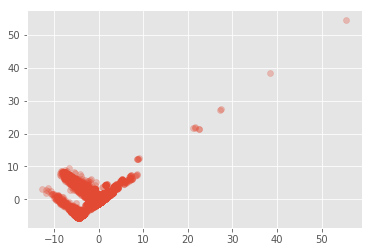

In [40]:
plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3)

In [41]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters,n_jobs=-1,random_state=1)
kmeans.fit(cc_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [42]:
X2d['label'] = kmeans.labels_
print (X2d.label.value_counts())

5    142904
1     74556
0     49422
4     17935
3      5418
2      4353
Name: label, dtype: int64


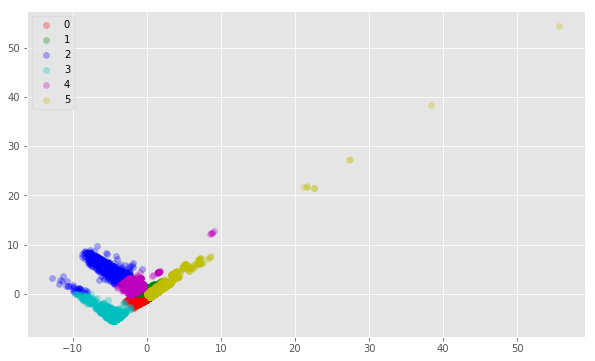

In [43]:
import itertools

colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

plt.rc('figure',figsize=(10,6))
for label in  range(n_clusters) :
    temp = X2d.loc[X2d.label == label,:]
    plt.scatter(temp.pc1,temp.pc2,c=next(colors),label=label,alpha=0.3)

plt.legend(loc='best')

In [44]:
X2d.label.value_counts()

5    142904
1     74556
0     49422
4     17935
3      5418
2      4353
Name: label, dtype: int64

In [45]:
#As we can see above that cluster 1 and cluster 2 are highly suspectable

Cluster 2

In [53]:
suspect1 = data2.loc[X2d.label==2,['credit_card','transaction_dollar_amount','50%_amount','credit_card_limit','date','distance']]
suspect1.sample(20)

,credit_card,transaction_dollar_amount,50%_amount,credit_card_limit,date,distance
58715,2891791194252089,54.85,25.490,5000,2015-09-18 22:23:34,11966.773608
288099,9757152469896436,100.48,120.935,24000,2015-08-07 22:23:44,8039.466067
168756,5930630722779265,41.60,141.350,35000,2015-10-12 21:14:22,11193.703091
17387,1475826831184689,84.45,59.570,20000,2015-08-14 21:19:09,9156.693573
83277,3612614294719592,29.41,67.150,20000,2015-09-10 00:34:21,8056.510936
144331,5285935774074579,18.56,36.965,15000,2015-10-29 21:16:28,11102.460172
279270,9552288592156524,9.00,87.740,30000,2015-08-28 23:36:27,12399.608059
68020,3199929867863316,22.93,31.970,8000,2015-10-08 02:33:58,9134.765279
228784,7804216189681274,58.19,73.550,20000,2015-10-05 18:08:01,12185.584173
177559,6219238634336382,11.95,101.270,20000,2015-08-25 19:36:45,9732.141231


In [47]:
#CLUSTER 3
suspect2 = data2.loc[X2d.label==3,['credit_card','transaction_dollar_amount','50%_amount','credit_card_limit','date','distance']]
suspect2.sample(20)

,credit_card,transaction_dollar_amount,50%_amount,credit_card_limit,date,distance
11608,1295205764436116,857.62,10.135,8000,2015-10-26 19:32:30,634.678072
193654,6780209767452752,843.20,139.695,35000,2015-10-21 18:42:58,630.079018
17544,1475826831184689,875.75,59.570,20000,2015-08-07 20:39:22,1654.425878
204793,7107467078128879,834.70,105.790,18000,2015-08-02 17:59:38,2075.152622
212503,7344275932115101,911.83,42.510,9000,2015-10-16 20:19:23,11.756271
81680,3547198874425548,965.70,24.790,5000,2015-10-26 22:37:10,624.376338
59397,2925559987432581,904.44,32.610,10000,2015-09-14 21:49:42,2.540556
158242,5697145338404683,807.39,53.590,8000,2015-09-25 22:14:47,629.169771
207202,7193900293112316,924.29,106.060,24000,2015-10-15 21:12:39,7.925485
241175,8185822588605701,993.32,39.840,12000,2015-10-16 19:41:07,1797.461313


In [48]:
#cluster 2 is suspectable for its long distance, while cluster 3 is suspectable for its huge amount.

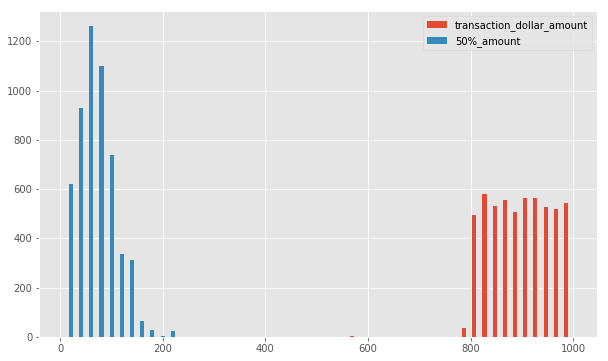

In [54]:
labels = ["transaction_dollar_amount","50%_amount"]
plt.hist(suspect2.loc[:,labels].values,bins=50,label=labels)
plt.legend(loc='best')